<a href="https://colab.research.google.com/github/svetaU/hmc/blob/main/HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import numpy as np
import scipy.stats as st
import math
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, writers

# HMC

In [298]:
def leapfrog(q, p, dUdq, num_steps, step_size, random_step=False,m = None):
  if random_step:
    step_size = np.random.uniform(step_size*0.8,step_size*1.2,1)
  if m is None:
    m = np.ones(len(p))
  q, p = np.copy(q), np.copy(p)
  p -= step_size * dUdq(q) / 2.0  
  leap_path = [np.copy(q)]
  for _ in range(num_steps - 1):
      q += step_size * p/m  
      p -= step_size * dUdq(q) 
      leap_path.append(np.copy(q))
  q += step_size * p/m  
  p -= step_size * dUdq(q) / 2 
  leap_path.append(np.copy(q)) 
  return (q,-p,leap_path)


In [304]:
def hamiltonian_monte_carlo(U, grad_U, current_position, steps=1, delta_t=0.5, change_step = False):
  q = np.copy(current_position)
  p = np.random.normal(0,0.6,len(q)) 
  current_momentum = np.copy(p)
  q, p, path = leapfrog(q,p,grad_U,steps,delta_t,change_step)
  current_U = U(current_position)
  current_K = sum(current_momentum*current_momentum) / 2
  proposed_U = U(q)
  proposed_K = sum(p*p) / 2
  if (np.log(np.random.rand()) < (current_U-proposed_U+current_K-proposed_K)):
    return (q,proposed_U,1,path) # accept
  else:
    return (current_position, current_U,0,None) # reject

# Test

In [106]:
def bivar_norm(x):
  m1 = 2.0
  m2 = 3.0
  x1 = x[0]
  x2 = x[1]
  s1 = math.sqrt(2.5)
  s2 = math.sqrt(1.6)
  corr = 0.4/s1/s2
  y = 1.0/(2.*math.pi*s1*s2*math.sqrt(1. - corr*corr))* \
    math.exp(-1.0/(2.0*(1-corr*corr))* \
             (((x1 - m1)/s1)**2 + ((x2 - m2)/s2))**2 - \
             2.0*corr*((x1 - m1)/s1)*((x2 - m2)/s2))
  return y

In [113]:
def log_bivar_norm(x):
  m1 = 2.0
  m2 = 3.0
  x1 = x[0]
  x2 = x[1]
  s1 = math.sqrt(2.5)
  s2 = math.sqrt(1.6)
  corr = 0.4/s1/s2
  y = -1.0/(2.0*(1-corr*corr))* (((x1 - m1)/s1)**2 + ((x2 - m2)/s2))**2 - 2.0*corr*((x1 - m1)/s1)*((x2 - m2)/s2)
  return -y    


In [120]:
def log_bivar_norm_grad(x):
  m1 = 2.0
  m2 = 3.0
  x1 = x[0]
  x2 = x[1]
  s1 = math.sqrt(2.5)
  s2 = math.sqrt(1.6)
  corr = 0.4/s1/s2
  y1 = -1.0/(2.0*(1-corr*corr))* (2.0*(x1 - m1)/s1/s1 - 2.0*corr*(x2 - m2)/s2/s1)
  y2 = -1.0/(2.0*(1-corr*corr))* (2.0*(x2 - m2)/s2/s2 - 2.0*corr*(x1 - m1)/s1/s2)
  return np.asarray([-y1,-y2])  

In [296]:
def test_hmc():
  target_mean = [2.,3.]
  target_cov = [[2.5,0.4],[0.4,1.6]]
  n_dots = 10000
  target_distribution_x, target_distribution_y = np.random.multivariate_normal(target_mean,target_cov,size=n_dots).T
  x_limits = (target_mean[0] - target_cov[0][0]*3,target_mean[0] + target_cov[0][0]*3)
  y_limits = (target_mean[1] - target_cov[1][1]*3,target_mean[1] + target_cov[1][1]*3)
  fig = plt.figure(figsize = (7,7))
  axes = fig.add_subplot(1,1,1)
  axes.set_xlim(x_limits[0],x_limits[1])
  axes.set_ylim(y_limits[0],y_limits[1])
  plt.scatter(target_distribution_x,target_distribution_y, c = 'blue', s=1, alpha = 0.3)
  points_to_sim = 800
  l_steps = 150
  burn = 100
  hmc_steps = np.asarray(range(points_to_sim+1-burn))
  #sim_dots = np.random.multivariate_normal(target_mean,target_cov,size=points_to_sim)
  sim_dots = []
  q = np.asarray([4.,6.])
  sim_dots.append(q)
  paths = []
  accept_rate = 0
  for i in range(points_to_sim):
    q, orbit,accept,l_path = hamiltonian_monte_carlo(log_bivar_norm,log_bivar_norm_grad,q,steps=l_steps,delta_t=0.02,change_step= True)
    sim_dots.append(q)
    paths.append(l_path)
    accept_rate = accept_rate + accept
  for point in sim_dots[burn:points_to_sim]:
    plt.scatter(point[0],point[1],c='red',s=30)
  for path in paths[burn:points_to_sim]:
    if path is not None:
      plt.plot(np.asarray(path)[:,0],np.asarray(path)[:,1], c='black')
  plt.title("Targeted pdf")
  plt.xlabel("x1")
  plt.ylabel("x2")  
  plt.show()
  print("Acceptance rate " + str(accept_rate/points_to_sim))
  print("First mean " + str(np.mean(np.asarray(sim_dots)[burn:,0])))
  print("Second mean " + str(np.mean(np.asarray(sim_dots)[burn:,1])))
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,0])
  plt.title("Trace plot x1")
  plt.xlabel("iteration")
  plt.ylabel("x1")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,1])
  plt.title("Trace plot x2")
  plt.xlabel("iteration")
  plt.ylabel("x2")  
  plt.show()

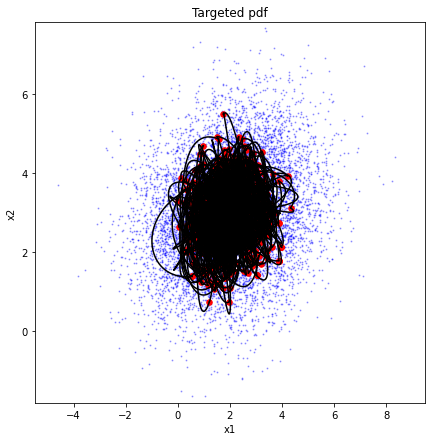

Acceptance rate 0.83375
First mean 2.0229937646986875
Second mean 2.8947317810459006


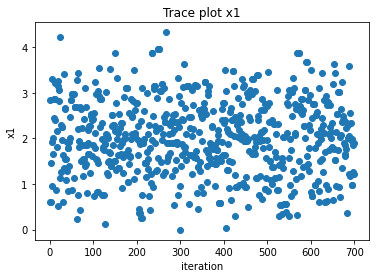

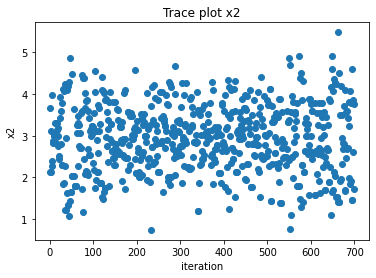

In [305]:
test_hmc()